# Oracle: Reflex Control with Look-Ahead

Steers the car using a PD controller on the estimated $y_m$ track median offset and track curve look-ahead.

In [4]:
import numpy as np
from DriveItMultiGym import DriveItEnv
from autopilot import LookAheadPilot
from car import Car
from utils import Color
from PositionTracking import TruePosition

num_episodes = 1
time_limit = 5.
noisy = True
random_position = True
speed_limit = 1.2

cars = [Car.HighPerf(Color.green, speed_limit)]
cars.append(Car.Simple(Color.orange, 1.0))
cars.append(Car.Simple(Color.purple, 1.0))
pilot = LookAheadPilot(cars[0], cars)
bots = [LookAheadPilot(car, cars, tracker_type=TruePosition, 
                       kka=0.0, kdka=2.0) for car in cars[1:]]

env = DriveItEnv(cars[0], bots, time_limit, noisy)
o = env._reset(random_position)
b = pilot.reset(o)
b_ = b
done = False
reward_episode = 0.0
reward_sum = 0.0
crashes = 0
obs, bel, pos, actions = [o], [b], [pilot.tracker.tracker.position], []

for i_episode in range(1, num_episodes + 1):
    
    while not done:
        if num_episodes < 2 and time_limit < 60.0:
            env.render()

        action = pilot.act()
        o, r, done, info = env.step(action)
        b = pilot.observe(o, env.dt)
        
        bel.append(b)
        obs.append(o)
        pos.append(pilot.tracker.tracker.position)
        actions.append(action)
        reward_episode += r

    if num_episodes <= 10:
        print('Episode %d %s. reward: %f' % \
              (i_episode, info['done'], reward_episode))

    if info['done'] != 'complete':
        crashes += 1

    reward_sum += reward_episode
    reward_episode = 0
    o = env._reset(random_position)
    o_ = o
    done = False

if num_episodes > 1:
    print('Average reward: %f with %d crashes' % \
          (reward_sum / num_episodes, crashes))

Episode 1 complete. reward: 4.901439


In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (12, 8)

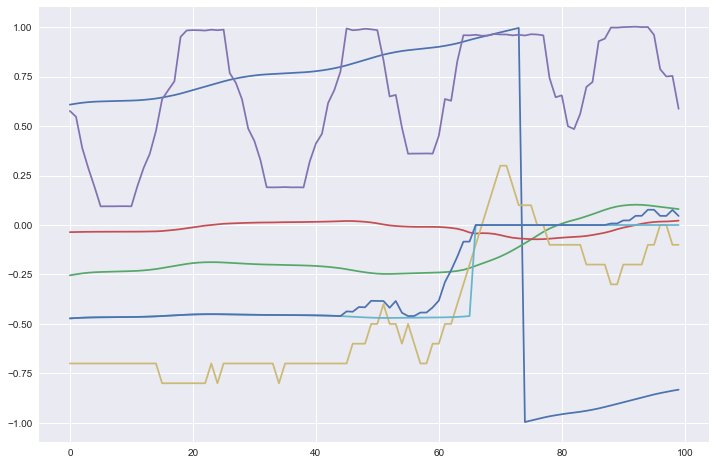

In [11]:
_ = plt.plot([b[:-5] for b in bel[-100:]])

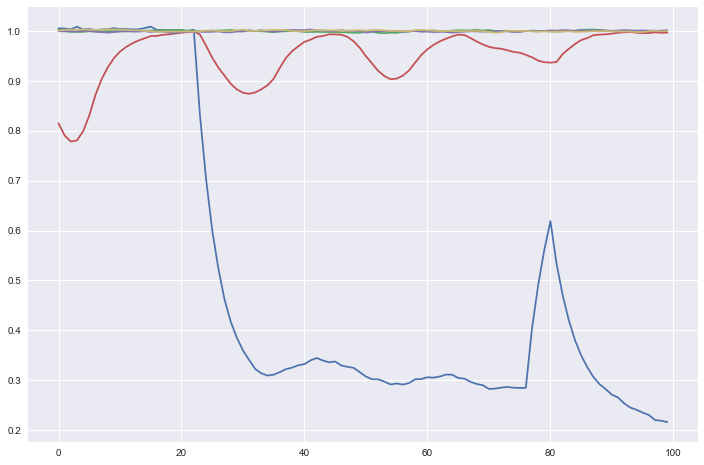

In [12]:
_ = plt.plot([b[-5:] for b in bel[-100:]])

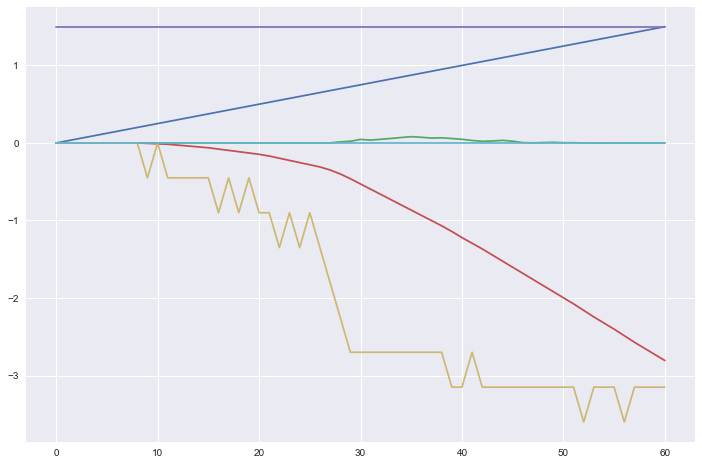

In [5]:
_ = plt.plot([o for o in obs])

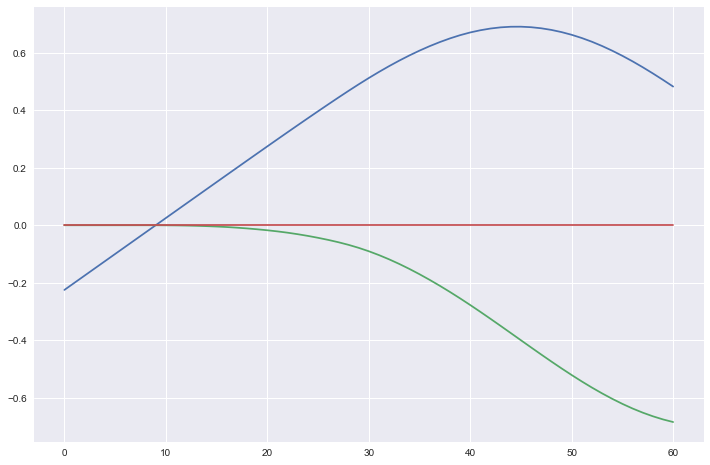

In [6]:
_ = plt.plot([p for p in pos])

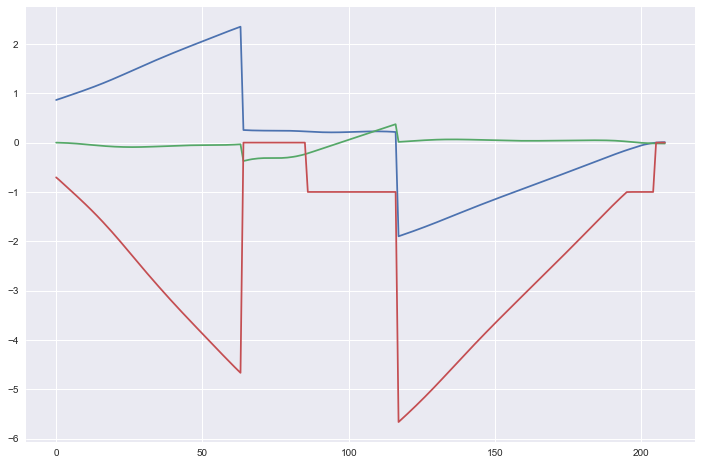

In [7]:
from DriveItCircuit import cartesian_to_median
posm = [cartesian_to_median(*p) for p in pos]
_ = plt.plot([p for p in posm])

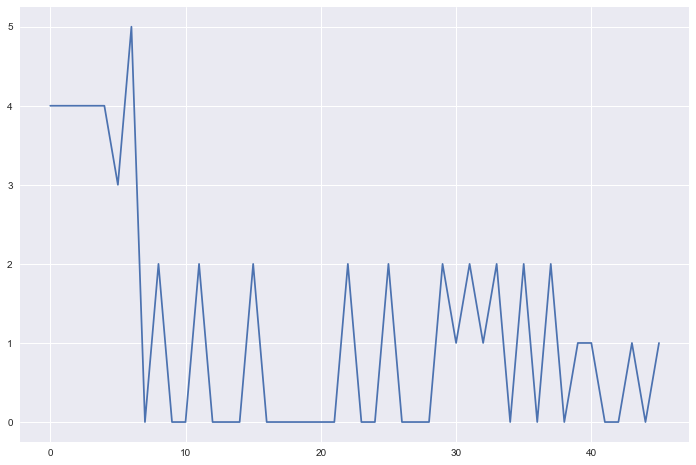

In [13]:
_ = plt.plot([a for a in actions])

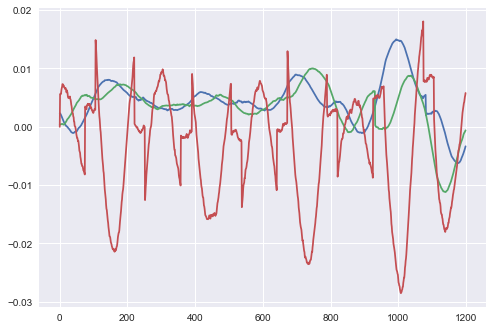

In [4]:
_ = plt.plot([e for e in err])

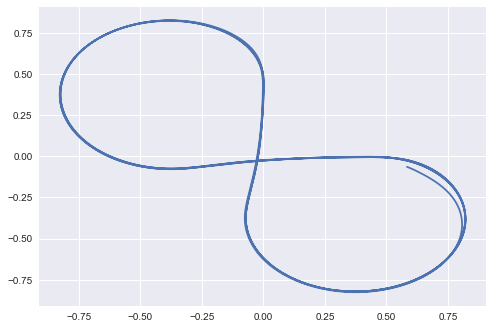

In [48]:
_ = plt.plot(x, y)

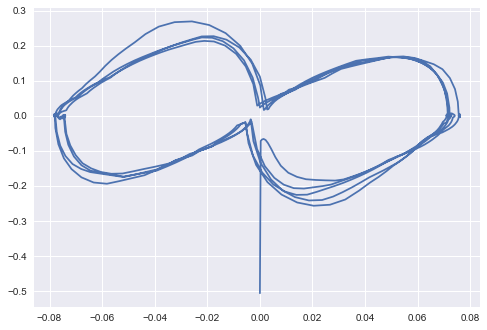

In [49]:
med = [(s[0],s[1],s[2]) for s in bel]
xm = [c[0] for c in med]
ym = [c[1] for c in med]
thm = [c[2] for c in med]
_ = plt.plot(ym, thm)

In [11]:
env._reset(random_position)

[array([-0.30159535,  0.        , -0.88246308,  0.        ,  2.21666667])]

In [12]:
env.render()